# Importing dependancies

In [1]:
import gym

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model definition

We can use the state variables (position of cart, angle of pole)

In [3]:
class DQN(nn.Module):

    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.LazyConv2d(16, 5, stride=2)
        self.conv2 = nn.LazyConv2d(32, 5, stride=2)
        self.conv3 = nn.LazyConv2d(32, 5, stride=2)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        self.flatten = nn.Flatten()
        
        self.fn1 = nn.LazyLinear(128)
        self.fn2 = nn.LazyLinear(output_size)

        self.act = nn.PReLU()

    def forward(self, input):
        x = self.act(self.bn1(self.conv1(input)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.act(self.fn1(x))
        output = self.fn2(x)
        return output

In [4]:
def get_screen(env, resize_shape):
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(resize_shape),
                    T.ToTensor()])
    return resize(screen)

# Memory
The agent should memorize what it learned before so it can learn from it

In [5]:
Experience = namedtuple('Experience', ('curr_state', 'action', 'next_state', 'reward', 'is_going'))

class Memory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def remember(self, *args):
        self.memory.append(Experience(*args))

    def recall(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        batch = Experience(*zip(*experiences))
        return batch

    def __len__(self):
        return len(self.memory)

# Creating the agent

In [6]:
class DQNAgent:
    def __init__(self, env):
        env.reset()
        self.action_size = env.action_space.n # output size
        
        self.model = DQN(self.action_size).to(device)

        self.loss_fn = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)

        self.exploration_rate = 1 # initial exploration rate, always leave at 1
        self.exploration_rate_decay = 0.9999 # rate at which the exploration decreases
        self.exploration_rate_min = 0.1 # minimun exploration rate
        
        self.gamma = 0.99 # falloff for Q score

        self.batch_size = 64
        self.num_epochs = 2000
        self.img_size = 60

        self.memory = Memory(10000) # how many of the previous samples are used
    
    def act(self, state):
        if random.random() < self.exploration_rate:
            action = random.randrange(self.action_size) # act randomly
        else:
            action = self.act_ideal(state) # act ideally
            
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
        return action
    
    def act_ideal(self, state):
        return self.model(state).max(1)[1].item()
    
    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.recall(self.batch_size)
        
        curr_states = torch.stack(batch.curr_state).squeeze(1)
        actions = torch.Tensor(batch.action).to(device)
        next_states = torch.stack(batch.next_state).squeeze(1)
        rewards = torch.Tensor(batch.reward).to(device)
        is_goings = torch.Tensor(batch.is_going).to(device)
        
        # This is the fundamental logic behind calulating a deep Q value.
        curr_Q = self.model(curr_states).mul(actions).sum(1)
        next_Q = self.model(next_states).max(1)[0]
        expected_Q = rewards + is_goings * self.gamma * next_Q

        loss = self.loss_fn(expected_Q, curr_Q)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 1)
        self.optimizer.step()
    
    def train(self, env, print_epochs=False):

        scores = []

        for epoch in range(self.num_epochs):
            done = False
            env.reset()
            curr_state = get_screen(env, self.img_size).to(device)
            score = 0
            
            while not done:

                action = self.act(curr_state.unsqueeze(0))
                _, reward, done, _ = env.step(action)
                next_state = get_screen(env, self.img_size).to(device)
                action_encode = np.eye(2)[action]
                self.memory.remember(curr_state, action_encode, next_state, reward, 1 - done)

                curr_state = next_state
                      
                self.train_step()

                score += 1
            
            scores.append(score)
            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))
            
        return scores


# Training the agent

C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Epoch: 1. Score is: 13
Epoch: 2. Score is: 13
Epoch: 3. Score is: 34


C:\Users\Sean Jan's PC\AppData\Local\Temp\ipykernel_12468\1983922221.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  actions = torch.Tensor(batch.action).to(device)


Epoch: 4. Score is: 31
Epoch: 5. Score is: 21
Epoch: 6. Score is: 37
Epoch: 7. Score is: 14
Epoch: 8. Score is: 20
Epoch: 9. Score is: 17
Epoch: 10. Score is: 27
Epoch: 11. Score is: 18
Epoch: 12. Score is: 74
Epoch: 13. Score is: 31
Epoch: 14. Score is: 17
Epoch: 15. Score is: 37
Epoch: 16. Score is: 15
Epoch: 17. Score is: 41
Epoch: 18. Score is: 20
Epoch: 19. Score is: 21
Epoch: 20. Score is: 43
Epoch: 21. Score is: 20
Epoch: 22. Score is: 26
Epoch: 23. Score is: 9
Epoch: 24. Score is: 14
Epoch: 25. Score is: 12
Epoch: 26. Score is: 27
Epoch: 27. Score is: 16
Epoch: 28. Score is: 16
Epoch: 29. Score is: 21
Epoch: 30. Score is: 19
Epoch: 31. Score is: 46
Epoch: 32. Score is: 20
Epoch: 33. Score is: 15
Epoch: 34. Score is: 42
Epoch: 35. Score is: 14
Epoch: 36. Score is: 31
Epoch: 37. Score is: 38
Epoch: 38. Score is: 23
Epoch: 39. Score is: 13
Epoch: 40. Score is: 13
Epoch: 41. Score is: 21
Epoch: 42. Score is: 16
Epoch: 43. Score is: 9
Epoch: 44. Score is: 46
Epoch: 45. Score is: 36


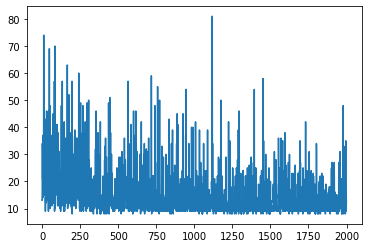

In [7]:
env = gym.make("CartPole-v0")
agent = DQNAgent(env)
scores = agent.train(env, print_epochs=True)
plt.plot(scores)
plt.show()

# Testing the agent

In [8]:
test_scores = []

for i in range(100):
    done = False
    env.reset()
    count = 0
    
    while not done:
        curr_screen = get_screen(env, agent.img_size).to(device)
        action = agent.act_ideal(curr_screen.unsqueeze(0))
        _, _, done, _ = env.step(action)
        count += 1
        
    test_scores.append(count)
    
avg = sum(test_scores) / 100
print(avg)

env.close()

9.38
